# Brevetti AI package installation

In [ ]:
pip install -U git+https://bitbucket.org/criterionai/core@CORE-22-add-augmentation-to-image-classi

  Cloning https://bitbucket.org/criterionai/core (to revision CORE-22-add-augmentation-to-image-classi) to /tmp/pip-req-build-wr0rcekg
  Running command git clone -q https://bitbucket.org/criterionai/core /tmp/pip-req-build-wr0rcekg
  Running command git checkout -b CORE-22-add-augmentation-to-image-classi --track origin/CORE-22-add-augmentation-to-image-classi
  Switched to a new branch 'CORE-22-add-augmentation-to-image-classi'
  Branch 'CORE-22-add-augmentation-to-image-classi' set up to track remote branch 'CORE-22-add-augmentation-to-image-classi' from 'origin'.
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 13.1MB 298kB/s 
     |████████████████████████████████| 1.1MB 39.6MB/s 
  Created wheel for brevetti-ai: filename=brevetti_ai-1.0-cp36-none-any.whl size=77209 sha256=7aeadb8232040695142920176216e3e2801e4a395041e63d0650122d4fcc0a54
  Stored in directory: /tmp/pip-ephem-wheel-cache-h86bz4bm/wheels/b5/b9/62/e085499540fd60c79a485a022c

# Get images from public dataset
Load publicly available dataset

In [ ]:
use_dataset = "brevetti_neurips_images"
if use_dataset == "brevetti_neurips_images":
    dataset_path = "s3://public.data.criterion.ai/data/NeurIPS_2018_reduced"
elif use_dataset == "tensorflow_flowers":
    import tensorflow as tf
    dataset_path = str(tf.keras.utils.get_file(
        'flower_photos',
        'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
        untar=True))
elif use_dataset == "tensorflow_datasets_beans":
    import tensorflow_datasets as tfds
    batch_size = 4

    ds = tfds.load("beans", split="test", shuffle_files=False)

    def encode(x):
        x["encoded"] = tf.io.encode_png(x["image"])
        return x
    def map2float(x):
        x["image"] = tf.cast(x["image"], tf.float32)
        return x
    img_ds = ds.map(encode).map(map2float)
    imgs = next(iter(img_ds.batch(batch_size).take(1)))
    files = []
    for ii in range(batch_size):
        files.append({"path": f"image_{ii}.png"})
        print(f'Writing file {files[-1]["path"]}')
        tf.io.write_file(files[-1]["path"], img["encoded"][ii])

    import pandas as pd
    files = pd.DataFrame(files)


## Create Brevetti AI Dataset object to manage listing of data (and access, if it where not publicly available)


In [ ]:
from brevettiai.platform.dataset import Dataset
ds = Dataset(bucket=dataset_path, resolve_access_rights=False)

# Fix to get access to a public bucket without credentials
ds.io.minio.client_factory("s3://public.data.criterion.ai", lambda **x:{"endpoint": "s3-eu-west-1.amazonaws.com"})

samples = ds.get_image_samples()
# Printing content of a sample from the pandas data frame
print("Sample: ", samples.sample(1).iloc[0].to_dict())

Sample:  {'category': ('good',), 'folder': 'good', 'path': 's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/good/6_1543412092080.bmp', 'etag': '354f746afe3c80ca246cea3cd1e2c5cf', 'bucket': 's3://public.data.criterion.ai/data/NeurIPS_2018_reduced', 'dataset': '', 'dataset_id': '', 'url': 'https://platform.brevetti.ai/download?path=lic.data.criterion.ai%2Fdata%2FNeurIPS_2018_reduced%2Fgood%2F6_1543412092080.bmp'}


samples now holds the image samples in a pandas dataframe object. We can investigate the distribution of the different classes

In [ ]:
samples.groupby("folder").count()

,category,path,etag,bucket,dataset,dataset_id,url
folder,,,,,,,
bad_cap,22,22,22,22,22,22,22
good,146,146,146,146,146,146,146
missing_cap,12,12,12,12,12,12,12


# Dataset split - sample integrity module
Functionality to split samples between training and development sets (often referred to as validation set, but this name is confusing in a regulated environment)

This module allows for more fine grained control of the splitting process than what is provided by e.g. sklearn.
The main feature is that it can split based on unique samples rather than just randomly. This is important when multiple images of the same physical item are available

In [ ]:
from brevettiai.data.sample_integrity import SampleSplit
from IPython.display import display 

uniqueness_regex = r"/(\d*)_\d*.bmp"

samples = SampleSplit(stratification=["folder"], uniqueness=uniqueness_regex, split=0.8).assign(samples, remainder="devel")
print("Devel samples")
display(samples[samples["purpose"] == "devel"][:5].path.values)
print("Train samples")
display(samples[samples["purpose"] == "train"][:5].path.values)

samples.groupby(["folder", "purpose"]).count()

Devel samples


array(['s3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/8_1543413181805.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/8_1543413191421.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/good/10_1543412092892.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/good/10_1543412102494.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/good/10_1543412160097.bmp'],
      dtype=object)

Train samples


array(['s3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/0_1543413169486.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/0_1543413189854.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/10_1543413182213.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/10_1543413191789.bmp',
       's3://public.data.criterion.ai/data/NeurIPS_2018_reduced/bad_cap/1_1543413257224.bmp'],
      dtype=object)

category  path  etag  bucket  dataset  dataset_id  url
folder      purpose                                                        
bad_cap     devel           2     2     2       2        2           2    2
            train          20    20    20      20       20          20   20
good        devel          28    28    28      28       28          28   28
            train         118   118   118     118      118         118  118
missing_cap devel           2     2     2       2        2           2    2
            train          10    10    10      10       10          10   10

# Data generator
The brevettiai DataGenerator object is a generator object that extents the functionality of tensorflow datasets by adding
* a generated random seed to the map function, so that an image augmentation pipeline may produce reproducible results
* the possibility for stratified sampling such that samples can be drawn with controlled freqeuncy from different groups of the dataset

the method get_dataset() returns a tensorflow dataset object with the above mentioned properties

In [ ]:
from brevettiai.data.data_generator import DataGenerator
from brevettiai.data import data_generator

batch_size = 4
# creating a data generator with stratification across a grouping on "folder" and with a weight determined by the square root of number of samples
generator = DataGenerator(samples, batch_size=batch_size, shuffle=True, repeat=True, sampling_groupby=["folder"], sampling_group_weighing="square root")

for sample in generator.get_dataset().take(2):
    print(sample["path"])

tf.Tensor(
[b'/root/.keras/datasets/flower_photos/daisy/14716799982_ed6d626a66.jpg'
 b'/root/.keras/datasets/flower_photos/roses/16051111039_0f0626a241_n.jpg'
 b'/root/.keras/datasets/flower_photos/sunflowers/4847062576_bae870479c_n.jpg'
 b'/root/.keras/datasets/flower_photos/tulips/7166552648_28b6dce578.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[b'/root/.keras/datasets/flower_photos/roses/5180896559_b8cfefc21e.jpg'
 b'/root/.keras/datasets/flower_photos/dandelion/7808545612_546cfca610_m.jpg'
 b'/root/.keras/datasets/flower_photos/daisy/5948835387_5a98d39eff_m.jpg'
 b'/root/.keras/datasets/flower_photos/roses/8502529435_c6e40d0df4.jpg'], shape=(4,), dtype=string)


The data generator uses stratified sampling across a grouping on "folder" and with a weight determined by the square root of number of samples.
We can investigate the frequency of samples vs the frequency of actual samples in the dataset

In [ ]:
import pandas as pd
from itertools import islice
drawn_samples = pd.DataFrame(islice(generator.get_dataset_numpy(batch=False), len(samples)))
print("Data generator sample frequency")
drawn_samples.groupby("folder").count()

Data generator sample frequency


,category,path,etag,bucket,dataset,dataset_id,url,_sampling_group
folder,,,,,,,,
daisy,738,738,738,738,738,738,738,738
dandelion,752,752,752,752,752,752,752,752
roses,715,715,715,715,715,715,715,715
sunflowers,715,715,715,715,715,715,715,715
tulips,750,750,750,750,750,750,750,750


# Image pipeline
The ImagePipeline object is a utility for
* reading a wide range of image formats and adding the reader to the tensorflow dataset graph
* (optionally) select region(s) of interest
* (optionally) rescale / pad the image to the desired output shape


In [ ]:
from brevettiai.data.image.image_pipeline import ImagePipeline

pipeline = ImagePipeline(target_size=(128, 128))
img_generator = generator.map(pipeline)

#The image generator now adds the loaded (and reshaped) image to the dataset execution graph, and per default the output is added using the "img" key

imgs_gen = next(iter(img_generator))
# imgs_gen now holds samples with an added image

# Image augmentation
* transformation augmentation (e.g. flip / rotate / sheare)
* image noise augmentation

Uses a seed so output is repeatable

In [ ]:
from brevettiai.data.image.image_augmenter import ImageAugmenter
img_aug = ImageAugmenter()
img_generator_aug = img_generator.map(img_aug)
imgs_aug = next(iter(img_generator_aug))
# The img_generator_aug produces repeatable samples, so taking the first batch a second time, should produce identical output
imgs_aug_repeated = next(iter(img_generator_aug))

## Drawing the same sample twice produces the same augmented images

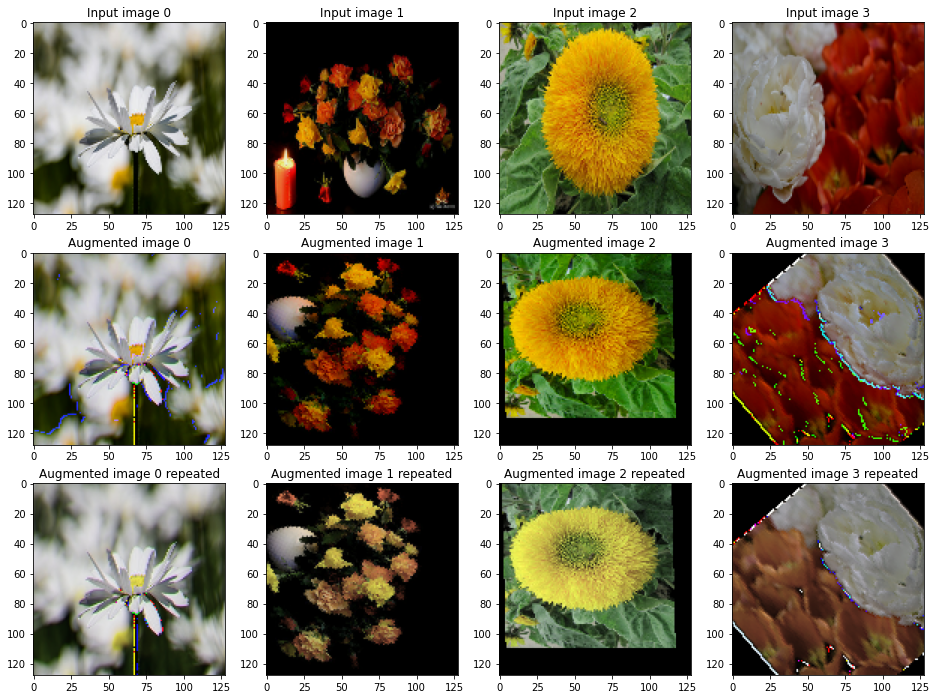

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, batch_size, figsize=(16, 12))
for ii in range(batch_size):
    ax[0, ii].imshow(tf.cast(imgs_gen["img"][ii], tf.uint8))
    ax[0, ii].set_title(f"Input image {ii}")
    ax[1, ii].imshow(tf.cast(imgs_aug["img"][ii], tf.uint8))
    ax[1, ii].set_title(f"Augmented image {ii}")
    ax[2, ii].imshow(tf.cast(imgs_aug_repeated["img"][ii], tf.uint8))
    ax[2, ii].set_title(f"Augmented image {ii} repeated")
